# Обучение модели классификации комментариев

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. В распоряжении набор данных с разметкой о токсичности правок.

**Задача**

Определение токсичности комментариев.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Таким образом, исследование пройдёт в три этапа:

1. Загрузка и подготовка данных.
2. Обучение моделей.
3. Тестирование лучшей модели.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
df = pd.read_csv("/datasets/toxic_comments.csv", index_col=0)
print(df.shape)
df.head()

(159292, 2)


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.duplicated().sum()

0

**Вывод** 

Файл содержит 2 столбца, из них 1 столбец имеют тип данных int64, 1 столбец object и  159292 строки. 

Столбец **text**  содержит текст комментария, а **toxic** — целевой признак.

Дубликаты не найдены. Пропущенные значения не обнаружены. 

**Исследуем баланс классов, проверим как часто в целевом признаке встречается клас "1" и "0.**

0    0.898388
1    0.101612
Name: toxic, dtype: float64


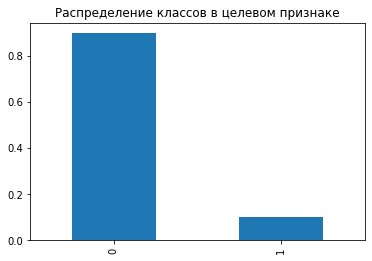

In [5]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar', title='Распределение классов в целевом признаке')
plt.show()

**Наблюдается сильный дисбаланс классов, соотношение классов 9:1.**

Приведем слова к нижнему регистру.

In [6]:
df['text'] = df['text'].str.lower()
df.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


Создадим столбец **lemm_text** с лемматизированным текстом.

In [7]:
def get_wordnet_pos(word):
   
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    word_list = nltk.word_tokenize(text)
    return " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
                     for word in word_list])     

In [9]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text) 
    clear_text = clear_text.split() 
    clear_text = " ".join(clear_text) 
    return clear_text

In [10]:
df['clear_text'] = df['text'].apply(clear_text)
df.head()

,text,toxic,clear_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


In [11]:
df['lemm_text'] = df['clear_text'].apply(lemmatize_text)
df.head()

,text,toxic,clear_text,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [12]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
target = df['toxic']
features = df['lemm_text']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(119469,)
(119469,)
(39823,)
(39823,)


In [14]:
features_train = count_tf_idf.fit_transform(features_train)
features_test = count_tf_idf.transform(features_test)
print(features_train.shape)
print(features_test.shape)


(119469, 127488)
(39823, 127488)


## Обучение моделей

### Логистическая регрессия

In [15]:
model_logist = LogisticRegression(random_state=12345)
parametrs_model_logist = {'max_iter': [50, 100, 200],
                          'solver': ['liblinear'],
                          'penalty': ['l1', 'l2']}

grid_model_logist = GridSearchCV(model_logist, parametrs_model_logist, cv=5, n_jobs=-1, scoring= 'f1')

grid_model_logist.fit(features_train, target_train) 
print('Лучшее значение F1-меры для модели  Логистическая регрессия:', grid_model_logist.best_score_,
     'с параметрами', grid_model_logist.best_params_)     

Лучшее значение F1-меры для модели  Логистическая регрессия: 0.7627041378733973 с параметрами {'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}


In [16]:
model_logist = LogisticRegression(random_state=12345, **grid_model_logist.best_params_)
model_logist.fit(features_train, target_train)
F1 = np.mean(cross_val_score(model_logist, features_train, target_train, cv=5,
                               scoring='f1'))

print('Среднее значение F1-мера для модели  Логистическая регрессия:', F1)

Среднее значение F1-мера для модели  Логистическая регрессия: 0.7627041378733973


### Случайный лес

In [17]:
model_forest = RandomForestClassifier(random_state=12345) 
parametrs_model_forest = {'n_estimators': range (5, 15, 2),
                          'max_depth': range (1, 11, 1),
                          'class_weight': ['balanced', None]}

grid_model_forest = GridSearchCV(model_forest, parametrs_model_forest, 
                              cv=5, n_jobs=-1, scoring='f1')

grid_model_forest.fit(features_train, target_train) 
print('Лучшее значение F1 для модели  Случайный лес:', grid_model_forest.best_score_,
     'с параметрами', grid_model_forest.best_params_)


Лучшее значение F1 для модели  Случайный лес: 0.29945340026446665 с параметрами {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 13}


In [18]:
model_forest = RandomForestClassifier(random_state=12345, 
                                      **grid_model_forest.best_params_) 
model_forest.fit(features_train, target_train) 

F1 = np.mean(cross_val_score(model_forest, features_train, target_train, cv=5,
                               scoring='f1'))

print('Среднее значение F1 для модели  Случайный лес:', F1)

Среднее значение F1 для модели  Случайный лес: 0.29945340026446665


## Тестирование лучшей модели

**Лучшей стала модель  Логистической регрессии с F1 = 0.76  с параметрами max_iter = 50, penalty = l1, solver = liblinear.**

In [19]:
model_best = LogisticRegression(random_state=12345, **grid_model_logist.best_params_)
model_best.fit(features_train, target_train)

predictions_test = model_best.predict(features_test)
probabilities_test = model_best.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

print("F1-мера наилучшей модели на тестовой выборке:", f1_score(target_test, predictions_test))
print("AUC-ROC на тестовой выборке =", roc_auc_score (target_test, probabilities_one_test))
print("Accuracy модели на тестовой выборке:", model_best.score(features_test, target_test))


F1-мера наилучшей модели на тестовой выборке: 0.7702627166014534
AUC-ROC на тестовой выборке = 0.9681278291237542
Accuracy модели на тестовой выборке: 0.9587173241594054


**Таким образом, тестирование подтвердило, что модель Логистическая регрессия лучшая.**

## Выводы

**Построены две модели машинного обучения с подбором гиперпараметров и метрики f1-меры:**

1. **Модель "Логистическая регрессия":** F1=0.76 с параметрами:
* max_iter = 50;
* penalty = l1;
* solver = liblinear.

2. **Модель "Случайный лес":** F1=0.3 с параметрами:
* class_weight = balanced;
* max_depth = 10;
* n_estimators = 13.

**Таким образом, наилучшиее значения f1-меры у модели "Логистическая регрессия": F1=0.76**

**Проведено тестирование лучшей модели** на тестовой выборки со следуюими результатами:
* F1-мера на тестовой выборке = 0.77;
* AUC-ROC на тестовой выборке = 0.97
* Accuracy модели на тестовой выборке = 0.96